# Credits

- The description of the Keras library was adapted from the Keras official documentation at https://keras.io/.

- Gentine, P., Pritchard, M., Rasp, S., Reinaudi, G., & Yacalis, G. ( 2018). Could machine learning break the convection parameterization deadlock? Geophysical Research Letters, 45, 5742– 5751. 
https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2018GL078202


# 7 - Parametrize Convection using Neural Networks

Representing unresolved moist convection in coarse‐scale climate models remains one of the main challenges of current climate simulations. The coarse resolution of these models is not sufficient to resolve the convective processes that produce rain.
In consequence, to represent the covection models rely on a parametrization that diagnose the precipitation at the ground from the model prognostic variables (humidity, temperature, pressure, etc.).

In this tutorial we will show how the convective parametrizations in a simple numerical climate model can be modeled using Neural Networks. 
The traning and testing data (model state variables and the precipitation) were created using the SPEEDY model. 
SPEEDY is a simplified GCM developed at ICTP by Franco Molteni and Fred Kucharski.  The ICTP AGCM (nicknamed SPEEDY, for "Simplified Parameterizations, privitivE-Equation DYnamics") is based on a spectral dynamical core developed at the Geophysical Fluid Dynamics Laboratory. It is a hydrostatic, s-coordinate, spectral-transform model in the vorticity-divergence form, with semi-implicit treatment of gravity waves.

In the following sections, we will cover the Neural Network basics and then create and train a Neural Network using the Keras python library.



## Contents  
<br>

1. [Introduction to Neural Networks](#IntroductionToNN)

    1. [What are Neural Networks](#WhatAreNN)
    1. [Neurons](#Neurons)
    1. [Activation Functions](#ActivationFunctions)
    1. [ForwardPropagation](#ForwardPropagation)
    1. [Training Neural Networks](#TrainingNN)
        1.[Getting started: 30 seconds to Keras](#GettingStartedToKeras)
1. [Parametrize convection using Neural networks](#ParametrizeConvection)
    1. [The climate model](#Speedy)
    1. [Training dataset](#Dataset)
    1. [Preparing the data](#Preprocessing)
    1. [Train my first neural network](#MyFirstNN)
    1. [Optimal neural network architecture and training parameters](#OptimalModel)
    
1. Credits
1. License




# Requirements 

This notebook was created to be used in google Colab, reading the input data files from Google Drive. 
That means that you need a google account to follow this notebook as it is. 

## Google Colab users 

Assuming that you already have a google account, to set up the environment needed for this tutorial follow these steps:

- In you google Drive, create a new directory in the root drive's root called "Datasets" 
- Upload the following files into that directory: https://drive.google.com/open?id=1tDGUqrkMWCSTQALJ28BdGqh70aw7i8nS
- Go to https://colab.research.google.com/ and upload this notebook (Python3)

Almost all the dependencies are already installed in the google colab environment. You are ready to go now! 

## Running jupyter notebook locally

If you want to run this notebook in your local computer, you need to download the files in https://drive.google.com/open?id=1tDGUqrkMWCSTQALJ28BdGqh70aw7i8nS and update the paths in this notebook to point to your local directories.


<a id='IntroductionToNN'></a>

# Introduction to Neural Networks

<a id='WhatAreNN'></a>
## What are Neural Networks

Neural networks are a type of machine learning models which are *losely inspired* in biological neurons and human nervous system. These models are used to recognize complex patterns and relationships that exists within a dataset. 

They have following properties:

1. The core architecture of a Neural Network model consists of a large number of simple processing nodes called **Neurons** which are interconnected and organized in different layers. 

2. An individual node in a layer is connected to several other nodes in the previous and the next layer. The inputs form one layer are received and processed to generate the output which is passed to the next layer.

3. The first layer of this architecture is often named as input layer which accepts the inputs, the last layer is named as the output layer which produces the output and every other layer between input and output layer is named is hidden layers. 


<img src="./fig/Neural_network_bottleneck_achitecture.svg" alt="https://upload.wikimedia.org/wikipedia/commons/8/8b/Neural_network_bottleneck_achitecture.svg" width="50%">

<a id='Neurons'></a>
## Neurons

A Neuron is a single processing unit of a Neural Network which are connected to different other neurons in the network. These connections repersents inputs and ouputs from a neuron. To each of its connections, the neuron assigns a “weight” (W) which signifies the importance the input and adds a bias (b) term. 

<img src="https://upload.wikimedia.org/wikipedia/commons/6/60/ArtificialNeuronModel_english.png" alt="https://upload.wikimedia.org/wikipedia/commons/6/60/ArtificialNeuronModel_english.png" width="85%">

<a id='ActivationFunctions'></a>
### Activation Functions 

The activation functions are used to apply non-linear transformation on input to map it to output. The aim of activation functions is to predict the right class of the target variable based on the input combination of variables. Some of the popular activation functions are Relu, Sigmoid, and TanH. 

<img src="https://cs-cheatsheet.readthedocs.io/en/latest/_images/activation_functions.png" alt="https://cs-cheatsheet.readthedocs.io/en/latest/_images/activation_functions.png" width="70%">

< Source: Stanford cs231n >

<a id='ForwardPropagation'></a>
### Forward Propagation 

Neural Network model compute the obtain the desired ouput through a process called forward propagation, in which it passes the computed activation outputs in the forward direction. 

$o_j= \varphi \left( \sum\limits_{i=1}^n x_i*w_{ij} + b_i) \right)$

Where: 

- $x_i$ : $i^{th}$ input to the neuron.
- *j* : the neuron number.
- $w_{ij}$ : weight associated with the $i^(th}$ input.
- $\varphi$ : the activation function.
- $b_i$ : the bias associated with the node for the $i^{th}$ input (neuron).
- $o_j$ : output value for the $j^{th}$ neuron.

Let's express the ouput values of a layer **O** in a more compact form using matrix notation:

$\vec{o}=\varphi \left( W \cdot \vec{x} + \vec{b} \right)$

Where: 

- $\vec{x}$ : Input vector (1D)
- $W$ : weights for each neuron and input (2D).
- $\varphi$ : the activation function.
- $\vec{b}$ : the bias associated with the node for each input (1D)
- $\vec{o}$ : output values (1D)

The arquitecture of the neural network and the weigths **W** and **b** represents our "model".
But a priori we don't know the exact value of the weigths and biases for our particular problem.

<a id='TrainingNN'></a>
## Training Neural Networks

To create a model that represents our data we adjust the weights gradually using a feedback signal from a set of know inputs and outputs, namely our training data.

To adjust our weights, we need a measure of how well our model is performing in the training data. For that we will can use a metric called "loss function" or "cost function" to measure the distance between our predicted and the expected output.

E.g.:

$Loss = Cost function = RMSE(Actual\_Values - Predicted\_Values)$
<a id='BackwardPropagation'></a>
### Backward Propagation

Neural Network model undergoes the process called backpropagation in which the error is passed to backward layers so that those layers can also improve the associated values of weights and bias. 

The backpropagation uses an algorithm called Gradient Descent in which the error is minimized and optimal values of weights and bias are obtained. This weights and bias adjustment is done by computing the derivative of error, derivative of weights, bias and subtracting them from the original values. 

<a id='KerasNN'></a>

## Neural networks using Keras

Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.


### Getting started: 30 seconds to Keras

The core data structure of Keras is a model, a way to organize layers. The simplest type of model is the Sequential model, a linear stack of layers. For more complex architectures, you should use the Keras functional API, which allows to build arbitrary graphs of layers.


Let's use keras to create a neural network like the one shown in the figure:

<img src="./fig/Neural_network_bottleneck_achitecture2.png?" alt="https://upload.wikimedia.org/wikipedia/commons/8/8b/Neural_network_bottleneck_achitecture.svg" width="50%">


Main characteristics:

- Number of input variables: **7** 
- Number of input layer nodes (1st layer): **5** 
- Number of first hidden layer nodes (2nd layer): **4**
- Number of second hidden layer nodes (3rd layer): **4**
- Number of ouput layer nodes (3th layer): **3**
- Activation functions

    - input and output layer: **relu** 
    - hidden layers: **sigmoid**

The Sequential model is a linear stack of layers.

In keras, a regular feed-forwards densely-connected NN layer is represented by the 
[keras.layers.Dense](https://keras.io/layers/core/#dense) class.

Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).


In [0]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

# Stacking layers is as easy as .add():

# Input layer. Here we specify the input shape.
model.add(Dense(units=5, activation='relu', input_dim=7)) 

# Hidden layers
model.add(Dense(units=4, activation='relu'))
model.add(Dense(units=4, activation='relu'))

#Output layer
model.add(Dense(units=3, activation='relu'))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


### Specifying the input shape

The model needs to know what input shape it should expect. For this reason, the first layer in a Sequential model (and only the first, because following layers can do automatic shape inference) needs to receive information about its input shape.


### Compilation

Before training a model, you need to configure the learning process, which is done via the compile method. It receives three arguments:

- An **optimizer**. This could be the string identifier of an existing optimizer (such as rmsprop or adagrad), or an instance of the Optimizer class. See: [optimizers](https://keras.io/optimizers/).
- A **loss** function. This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function (such as categorical_crossentropy or mse), or it can be an objective function. See: [losses](https://keras.io/losses/).
- A list of **metrics**. For any classification problem you will want to set this to metrics=['accuracy']. A metric could be the string identifier of an existing metric or a custom metric function. [See available metrics here](https://keras.io/metrics/). The loss functions can also be used as metrics!

Let's compile our model:

In [0]:
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
# sgd = Stochastic gradient descent optimizer.             

### Training

Keras models are trained on Numpy arrays of input data and labels. For training a model, you will typically use the fit function. Read its documentation [here](https://keras.io/models/sequential/).

E.g.: Train the model, iterating on the data in batches of 32 samples


---


`history = model.fit(x_data, y_data, epochs=10, batch_size=32)`


---



Where: 
- **epochs**: Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided. Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The training process may consist in more than one epoch.

- **batch_size**: Number of samples per gradient update. If unspecified, batch_size will default to 32.

- **history**:  A History object. Its History.history attribute is a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable).

### Predict

The **predict** method generates output predictions for the input samples. 

---

`predicted_values = model.predict(x, batch_size=None, verbose=0, steps=None, callbacks=None)`

---

The computation is done in batches.


### evaluate

The **evaluate**  method returns the loss value & metrics values for the model in test mode.

---

`evaluate(x=None, y=None, batch_size=None, verbose=1)`

---


Now, let's use Keras to parametrize convection.

# Parametrize convection using Neural networks


Representing unresolved moist convection in coarse‐scale climate models remains one of the main challenges of current climate simulations. The coarse resolution of these models is not sufficient to resolve the convective processes that produce rain.
In consequence, to represent the covection models rely on a parametrization that diagnose the precipitation at the ground from the model prognostic variables (humidity, temperature, pressure, etc.).

In this part of the tutorial we will try to use a Neural Network to learn the convective parametrization used in simplified climate model. 

## The model

To generate the traning data (state variables and the precipitation) we will use the SPEEDY model.
SPEEDY is a simplified GCM developed at ICTP by Franco Molteni and Fred Kucharski.

The ICTP AGCM (nicknamed SPEEDY, for "Simplified Parameterizations, privitivE-Equation DYnamics") is based on a spectral dynamical core developed at the Geophysical Fluid Dynamics Laboratory. It is a hydrostatic, s-coordinate, spectral-transform model in the vorticity-divergence form, with semi-implicit treatment of gravity waves.

- https://www.ictp.it/research/esp/models/speedy.aspx
- Molteni F (2003) Atmospheric simulations using a GCM with simplified physical  parametrizations. I. Model climatology and variability in multi-decadal experiments. Clim Dyn 20: 175-191

- Kucharski F, Molteni F, and Bracco A (2006) Decadal interactions between the western tropical Pacific and the North Atlantic Oscillation. Clim Dyn 26: 79-91

## Training dataset

The training dataset was generated by running the model for 10 years with a spatial resolution of approx. 2 degrees. The main characteristics of the dataset are:

- T30 horizontal resoltution (approx. 2 degrees)
- Outputs variables available every 6h for a 10 yr period
- Only the latitudes between -30 and 30 degress are included

Let's first take a look at the dataset.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os

os.listdir('/content/gdrive/My Drive/Datasets')

['gcm_run_3.nc', 'train_3.nc', 'train_4.nc']

In [0]:
# We need to install the netcdf4 libraries to read the files
!pip install netcdf4

     |████████████████████████████████| 4.1MB 4.9MB/s 
     |████████████████████████████████| 307kB 32.7MB/s 


In [0]:
import xarray as xr
import numpy as np

dataset = xr.open_dataset('/content/gdrive/My Drive/Datasets/gcm_run_3.nc', chunks=dict(time = 100))

Let's see the variables in the dataset.

In [0]:
list(dataset.variables.keys())

['time', 'lon', 'lat', 'lev', 'gh', 'temp', 'q', 'sp', 'precnv']

- coordinates: 'time', 'lon', 'lat', 'lev'
- prognostic variables: 'gh', 'temp', 'q', 'sp'
- diagnostic variable: 'precnv'

Let's check the times in the dataset 

In [0]:
print("First date: " , dataset['time'].values.min())
print("Last date: " , dataset['time'].values.max())

First date:  2003-01-01T00:00:00.000000000
Last date:  2003-12-31T18:00:00.000000000


Let's see in more detail the contents of the dataset.

In [0]:
dataset

<xarray.Dataset>
Dimensions:  (lat: 16, lev: 8, lon: 96, time: 1460)
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01 ... 2003-12-31T18:00:00
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * lat      (lat) float64 -27.83 -24.12 -20.41 -16.7 ... 16.7 20.41 24.12 27.83
  * lev      (lev) float64 925.0 850.0 700.0 500.0 300.0 200.0 100.0 30.0
Data variables:
    gh       (time, lev, lat, lon) float32 dask.array<shape=(1460, 8, 16, 96), chunksize=(100, 8, 16, 96)>
    temp     (time, lev, lat, lon) float32 dask.array<shape=(1460, 8, 16, 96), chunksize=(100, 8, 16, 96)>
    q        (time, lev, lat, lon) float32 dask.array<shape=(1460, 8, 16, 96), chunksize=(100, 8, 16, 96)>
    sp       (time, lat, lon) float32 dask.array<shape=(1460, 16, 96), chunksize=(100, 16, 96)>
    precnv   (time, lat, lon) float32 dask.array<shape=(1460, 16, 96), chunksize=(100, 16, 96)>
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg

In nutshell, the shape of the model prognostic variables (our predictors) :

- __gh(time, lev, lat, lon)__ = **gh(1460, 8, 16, 96)** = geopotential height [m]
- __temp(time, lev, lat, lon)__ = **temp(1460, 8, 16, 96)** = abs. temperature [degK]
- __q(time, lev, lat, lon)__ = **q(1460, 8, 16, 96)** = specific humidity [g/Kg]
- __sp(time, lat, lon)__ = **sp(1460, 16, 96)** = surface pressure [hPa]

The shape of the diagnosed precipitation (the predicted variable) is:
- __precnv(time, lat, lon)__ = **precnv(1460, 16, 96)** = convective precipitation [mm/day]

In [0]:
# Let's remove the unnecessary attributes to have cleaner outputs
dataset.attrs=dict()

## Prepare the data

We are going to predict the precipitation at each grid point using the information from the predictor variables in the corresponding column.

Therefore, the input variables to the Neural network consist of

- __Input__: $\vec{x}= \left\{ gh(z), temp(z), q(z), sp \right\}$, with a length of $\vec{x}$ is 8+8+8+1=25.
- __Output__: R, the precipitation at the ground with length=1.

The training samples in the dataset consist in many columns for every time step. Hence, based on the amount of data in dataset we have:

$total\_samples=number\_of\_times*number\_of\_lats*number\_of\_lons$

$total\_samples=1460*16*96=2242560$

**That is more than 2 millon samples per year!**


### Step 1: Collapse dimensions 

In the original dataset the dimensions of our variables are (time, lev, lat, lon) or (time, lat, lon).
What we want to feed to the Neural network are arrays with shape x=(samples, variables) and y=(samples).

Therefore, we have to collapse the (time, lat, lon) dimensions into a single dimension (sample).

We will create a function to do that for a given dataset and save the results into a file for future use.
Saving the preprocessed data to a file will also help to mainting the memory requirements to the minimum.

But, before we create that function, let's see this how this preprocessing is done step by step using a small dataset.

In [0]:
# Select 100 times only (20*16*96=30720 column samples)
small_dataset = dataset.isel(time=slice(0,20))
dict(small_dataset.dims)

{'lat': 16, 'lev': 8, 'lon': 96, 'time': 20}

To collapse the (time, lat, lon) dimensions into a single dimension (sample) we will use the [Dataset's stack](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.stack.html#xarray.Dataset.stack) method.

This method stack any number of existing dimensions into a single new dimension. The new dimension will be added at the end, and the corresponding coordinate variables will be combined into a MultiIndex.


In [0]:
stacked_dataset = small_dataset.stack(sample=('time', 'lat', 'lon'))
stacked_dataset

<xarray.Dataset>
Dimensions:  (lev: 8, sample: 30720)
Coordinates:
  * lev      (lev) float64 925.0 850.0 700.0 500.0 300.0 200.0 100.0 30.0
  * sample   (sample) MultiIndex
  - time     (sample) datetime64[ns] 2003-01-01 2003-01-01 ... 2003-01-01
  - lat      (sample) float64 -27.83 -27.83 -27.83 ... -27.83 -27.83 -27.83
  - lon      (sample) float64 0.0 3.75 7.5 11.25 15.0 ... 97.5 101.2 105.0 108.8
Data variables:
    gh       (lev, sample) float32 dask.array<shape=(8, 30720), chunksize=(8, 30720)>
    temp     (lev, sample) float32 dask.array<shape=(8, 30720), chunksize=(8, 30720)>
    q        (lev, sample) float32 dask.array<shape=(8, 30720), chunksize=(8, 30720)>
    sp       (sample) float32 dask.array<shape=(30720,), chunksize=(30720,)>
    precnv   (sample) float32 dask.array<shape=(30720,), chunksize=(30720,)>
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Wed May 08 08:57:29 2019: cdo -

Let's reorder the variables dimensions as (sample, lev)

In [0]:
stacked_dataset = stacked_dataset.transpose('sample', 'lev')
stacked_dataset

<xarray.Dataset>
Dimensions:  (lev: 8, sample: 30720)
Coordinates:
  * lev      (lev) float64 925.0 850.0 700.0 500.0 300.0 200.0 100.0 30.0
  * sample   (sample) MultiIndex
  - time     (sample) datetime64[ns] 2003-01-01 2003-01-01 ... 2003-01-01
  - lat      (sample) float64 -27.83 -27.83 -27.83 ... -27.83 -27.83 -27.83
  - lon      (sample) float64 0.0 3.75 7.5 11.25 15.0 ... 97.5 101.2 105.0 108.8
Data variables:
    gh       (sample, lev) float32 dask.array<shape=(30720, 8), chunksize=(30720, 8)>
    temp     (sample, lev) float32 dask.array<shape=(30720, 8), chunksize=(30720, 8)>
    q        (sample, lev) float32 dask.array<shape=(30720, 8), chunksize=(30720, 8)>
    sp       (sample) float32 dask.array<shape=(30720,), chunksize=(30720,)>
    precnv   (sample) float32 dask.array<shape=(30720,), chunksize=(30720,)>
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Wed May 08 08:57:29 2019: cdo -

The last step is to create the (x, y) training samples, where their dimensions are:
- x(samples, variables)
- y(samples)

For each column, to aggregate all the variables data into a single dimension, we will use the [numpy's append](https://docs.scipy.org/doc/numpy/reference/generated/numpy.append.html) function.
This function append new values to the end of an array.

In [0]:
# The number of dimensions of x are x(samples, variables)

# "sp" dimensions were (time, lat, lon). After we collapse these dimensions into "sample"
# it became a 1D variable.

# To start appending all the column data into a the dimension variable,
# let's reshape sp to (samples, 1)
x = stacked_dataset['sp'].values[:,None]
# (None is the same as np.newaxis) 

# Now, let's continue adding the data into the second dimension
for variable in ['gh', 'temp', 'q']:
    x=np.append(x, stacked_dataset[variable].values, axis=1)

y = stacked_dataset['precnv'].values

In [0]:
print('x.shape=', x.shape)
print('y.shape=', y.shape)

x.shape= (30720, 25)
y.shape= (30720,)


Now let's create a function that implements the preprocessing step for a given dataset (netcdf file) and save the preprocessed data into a Netcdf file for further use. In this way, we only do this preprocessing once.

In [0]:
def collapse_dims(input_dataset_path, output_dataset_path):
    """
    Prepare the training samples from the input dataset for the Neural Network.
    
    x=(samples, variables) and y=(samples).
    
    Parameters
    ----------
    
    input_dataset_path: str
        Path to the netcdf file with the original SPEEDY output
    
    output_dataset_path: str
        Path to the output netcdf file with the preprocessed dataset
        
    """
    
    # Since we are working in a Jupyter notebook, to make sure that we are not
    # modifying any variable defined outside the function, 
    # we prepend an underscore to the function local variables.
    
    _input_dataset = xr.open_dataset(input_dataset_path)
    
    _stacked_dataset = _input_dataset.stack(sample=('time', 'lat', 'lon'))
    
    _stacked_dataset = _stacked_dataset.transpose('sample', 'lev')
    
    _x = _stacked_dataset['sp'].values[:,None]
    for variable in ['gh', 'temp', 'q']:
        _x=np.append(_x, _stacked_dataset[variable].values, axis=1)

    _y = _stacked_dataset['precnv'].values
    
    #Create an xarray dataset to save the file to netcdf
    _new_dataset = xr.Dataset({'x': (['samples', 'variables'],  _x),
                             'y': (['samples'], _y)} )
    
    
    #Save dataset
    _new_dataset.to_netcdf(output_dataset_path)
    print(f"Preprocesses file saved: {output_dataset_path}")
    

Now, let's process all the input files.

In [0]:
collapse_dims('/content/gdrive/My Drive/Datasets/gcm_run_3.nc', '/content/gdrive/My Drive/Datasets/train_3.nc')
collapse_dims('/content/gdrive/My Drive/Datasets/gcm_run_4.nc', '/content/gdrive/My Drive/Datasets/train_4.nc')

Preprocesses file saved: /content/gdrive/My Drive/Datasets/train_3.nc


FileNotFoundError: ignored

Step 2: Load the preprocessed files

In [0]:
input_dataset = xr.open_mfdataset(['/content/gdrive/My Drive/Datasets/train_3.nc'])


# i_sam = input_dataset.samples[(1<input_dataset['y']) & (input_dataset['y']<100)]

# input_dataset = input_dataset.isel(samples=i_sam)
input_dataset

<xarray.Dataset>
Dimensions:  (samples: 2242560, variables: 25)
Dimensions without coordinates: samples, variables
Data variables:
    x        (samples, variables) float32 dask.array<shape=(2242560, 25), chunksize=(2242560, 25)>
    y        (samples) float32 dask.array<shape=(2242560,), chunksize=(2242560,)>

## Train my first neural network


### Train and validation datasets

In the completa dataset we have 10 years of data. We will use year 3 (train_3.nc) as training dataset and year 4 (train_4.nc) as validation dataset. 

In [0]:
train_dataset = xr.open_dataset('/content/gdrive/My Drive/Datasets/train_3.nc')

test_dataset = xr.open_dataset('/content/gdrive/My Drive/Datasets/train_4.nc')

In [0]:
train_dataset

<xarray.Dataset>
Dimensions:  (samples: 2242560, variables: 25)
Dimensions without coordinates: samples, variables
Data variables:
    x        (samples, variables) float32 ...
    y        (samples) float32 ...

In [0]:
test_dataset


<xarray.Dataset>
Dimensions:  (samples: 2242560, variables: 25)
Dimensions without coordinates: samples, variables
Data variables:
    x        (samples, variables) float32 ...
    y        (samples) float32 ...

Let's define new variables with only the numpy arrays values of the Datasets. This will make the computation times more efficient in the future.

In [0]:
x_train = train_dataset['x'].values
y_train = train_dataset['y'].values

x_test = test_dataset['x'].values
y_test = test_dataset['y'].values

#### Data normalization
For an ANN to train efficiently, all input values should be on the same order of magnitude. For this purpose, for each input variable, we subtracted the mean and divided by the standard deviation, independently for each vertical level.

We will train the scaler with the training data only!

In [0]:
from sklearn.preprocessing import StandardScaler


input_scaler = StandardScaler()
input_scaler.fit(x_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

Now let's normalize the train and the tests input data.

In [0]:
x_train_normed = input_scaler.transform(x_train)
x_test_normed = input_scaler.transform(x_test)

Now the input and the test data is ready to be used by the Neural Network! 

Be aware that the normalization is only done in the input data!, there is no need to normalize the output. 

Using TensorFlow backend.


### Construct the Neural Network

Let's construct a small Neural Network with no hidden layers to show how the training process is done and how to evaluate the NN on the test dataset.

The example neural network has the following structure:

- Input: $\vec{x}$ (length 25)
- Output: R (length 1).

- Input layer (1st layer): **25 nodes, relu activation function** 
- Output layer (4th layer): **1 nodes, relu activation function** 

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as keras_bck


my_model = Sequential()

# Input layer. Here we specify the input shape.
my_model.add(Dense(units=25, activation='relu', input_dim=25)) 

# No hidden layers 

# Output layer
my_model.add(Dense(units=1, activation='relu'))



# Let's define the metric used to evaluate the performance of the Neural Network
def root_mean_squared_error(y_true, y_pred):
    """
    Root Mean Square error metric
    
    Parameters
    ----------
    
    y_true : ndarray
        Expected output values
    
    y_pred : ndarray
        Predicted output values by the NN
    """
    return keras_bck.sqrt( keras_bck.mean(keras_bck.square(y_pred - y_true), 
                                          axis=-1)
                         ) 
    

# Compile the model
my_model.compile(optimizer='Adam', loss='mse', 
                 metrics=[root_mean_squared_error])

### Train the model

In [0]:
train_history = my_model.fit(x=x_train_normed,y=y_train ,
                             validation_data=(x_test_normed,y_test), 
                             epochs=10, 
                             verbose=1,
                             shuffle=True)

Train on 2242560 samples, validate on 2242560 samples
Epoch 1/10
2242560/2242560 [==============================] - 248s 110us/step - loss: 79.7313 - root_mean_squared_error: 3.2069 - val_loss: 63.1152 - val_root_mean_squared_error: 2.4790
Epoch 2/10
2242560/2242560 [==============================] - 249s 111us/step - loss: 50.3852 - root_mean_squared_error: 2.1551 - val_loss: 42.6219 - val_root_mean_squared_error: 1.9114
Epoch 3/10
2242560/2242560 [==============================] - 248s 111us/step - loss: 38.9018 - root_mean_squared_error: 1.7320 - val_loss: 36.6113 - val_root_mean_squared_error: 1.6032
Epoch 4/10
2242560/2242560 [==============================] - 250s 111us/step - loss: 34.1436 - root_mean_squared_error: 1.5471 - val_loss: 32.5240 - val_root_mean_squared_error: 1.5048
Epoch 5/10
2242560/2242560 [==============================] - 247s 110us/step - loss: 31.8290 - root_mean_squared_error: 1.4493 - val_loss: 30.7484 - val_root_mean_squared_error: 1.4312
Epoch 6/10
22425

The output history (train_history variable) has a .history attribute with the record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable).

Let's analyze how did the training go.



In [0]:
train_history.history # Dictionary with 

{'loss': [79.73129231425501,
  50.385206154129136,
  38.90176599443321,
  34.143571726732496,
  31.829025845643432,
  30.46940569467214,
  29.62523174346055,
  28.854266893409676,
  28.2731449630352,
  27.970773210681983],
 'root_mean_squared_error': [3.2068657096022792,
  2.155126676455556,
  1.7320222892677135,
  1.5471085360640382,
  1.4492520202859445,
  1.3860833180658085,
  1.3425033650375122,
  1.3078937668465689,
  1.27748744953314,
  1.259692671091337],
 'val_loss': [63.115180361162885,
  42.62190312983996,
  36.61131061681093,
  32.52402762009935,
  30.748406270756366,
  31.083195596963705,
  28.647869809958213,
  27.780735362944306,
  27.78702096275572,
  28.014210752714302],
 'val_root_mean_squared_error': [2.4790030869751325,
  1.9114497267500574,
  1.6031879009002712,
  1.504849677128393,
  1.4311507726024393,
  1.4311205327687966,
  1.3305620676392615,
  1.2845266011709373,
  1.261248806714675,
  1.2964961796714567]}

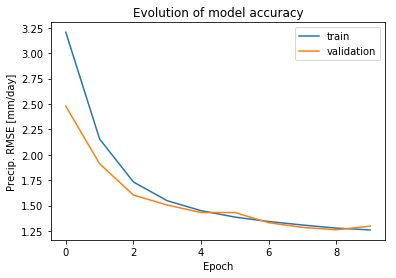

In [0]:

import matplotlib.pyplot as plt
plt.plot(train_history.history['root_mean_squared_error'], label="train")
plt.plot(train_history.history['val_root_mean_squared_error'], label="validation")
plt.legend()

plt.title("Evolution of model accuracy")
plt.xlabel('Epoch')
plt.ylabel('Precip. RMSE [mm/day]')
plt.show()


Let's see how the precipitation patterns looks like with the trained NN.

## Predicted precipitation patterns


In [0]:
# Remember that the model uses the standarized values! 
predicted_precip = my_model.predict(x_test_normed)

In [0]:
predicted_precip.max()

139.1036

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 2242560 + 1) instead
  


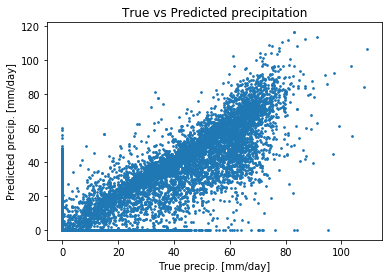

In [0]:
import matplotlib.pyplot as plt
import numpy as np


# Select randomly a few samples. Otherwise, the plot will take to long.
selected_indexes = np.random.random_integers(0, high=y_test.size, size=100_000)


plt.scatter(y_test.ravel()[selected_indexes], 
            predicted_precip.ravel()[selected_indexes],
            s=3)

plt.title("True vs Predicted precipitation")

plt.xlabel('True precip. [mm/day]')
plt.ylabel('Predicted precip. [mm/day]')
plt.show()

The results does not very encouraging, right? But, consider that we only trained for 10 epochs and we use a very simple network architecture. 

The goal of this first part was just to familiarize with the steps to train and use a neural network. To accurately parametrize convection with Neural Networks we will need to explore different networks architectures and find the best training parameters. 


## Find the optimal neural network architecture and training parameters

Now that we know how to build and train a neural network, we can evaluate different network arquitectures (more layers, more neurons, different activation functions, different optimizers, etc) and find the optimal training parameters.


To be continued.....

# Credits

- The description of the Keras library was adapted from the Keras official documentation at https://keras.io/.

- Gentine, P., Pritchard, M., Rasp, S., Reinaudi, G., & Yacalis, G. ( 2018). Could machine learning break the convection parameterization deadlock? Geophysical Research Letters, 45, 5742– 5751. 
https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2018GL078202

# License

### Mit License

Copyright 2019 Andres Perez Hortal

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.